In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import os
import torch

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss

from lightning.pytorch.tuner import Tuner

import warnings
warnings.filterwarnings('ignore')

/Users/filipp/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/filipp/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
dirname = os.path.join(os.path.abspath(os.curdir), 'data', 'underwork')

raw_data = {"3":(), "5":(), "8":(), "10":(), "14":(), "15":()}
for v in raw_data:
    tsdf_c = pd.read_csv(os.path.join(os.sep, dirname, v, 'calm_p.csv'))
    tsdf_w = pd.read_csv(os.path.join(os.sep, dirname, v,  'work_p.csv'))
    tsdf_m = pd.read_csv(os.path.join(os.sep, dirname, v, 'meta_p.csv'))
    raw_data[v] = (tsdf_c, tsdf_w, tsdf_m)

In [3]:
data = {"3":(), "5":(), "8":(), "10":(), "14":(), "15":()}

for v in raw_data:
    calm = raw_data[v][0]
    # calm = calm[calm["Time"] < 60]
    # calm["Time"] = calm["Time"] * 10000
    work = raw_data[v][1]
    # work = work[work["Time"] < 60]
    # work["Time"] = work["Time"] * 10000
    sex = raw_data[v][2].iloc[0]["values"]
    weight = raw_data[v][2].iloc[1]["values"]
    height = raw_data[v][2].iloc[2]["values"]
    calm["sex"] = sex
    calm["weight"] = weight
    calm["height"] = height
    calm["state"] = 0
    work["sex"] = sex
    work["weight"] = weight
    work["height"] = height
    work["state"] = 1
    data[v] = (calm, work)

In [4]:
validation = {"25":(), "27":()}
for v in validation:
    calm = pd.read_csv(os.path.join(os.sep, dirname, v, 'calm_p.csv'))
    work = pd.read_csv(os.path.join(os.sep, dirname, v,  'work_p.csv'))
    tsdf_m = pd.read_csv(os.path.join(os.sep, dirname, v, 'meta_p.csv'))
    sex = tsdf_m.iloc[0]["values"]
    weight = tsdf_m.iloc[1]["values"]
    height = tsdf_m.iloc[2]["values"]
    calm["sex"] = sex
    calm["weight"] = weight
    calm["height"] = height
    calm["state"] = 0
    work["sex"] = sex
    work["weight"] = weight
    work["height"] = height
    work["state"] = 1
    validation[v] = (calm, work)

In [5]:
data["3"][1].head()

,Time,1,2,3,4,5,6,sex,weight,height,state
0,0.000,0.885328,0.436734,1.366469,1.964314,1.034510,0.901406,0.0,76.0,187.0,1
1,0.001,0.884544,0.437911,1.369214,1.964314,1.033333,0.903366,0.0,76.0,187.0,1
2,0.002,0.884152,0.437911,1.369606,1.964314,1.032941,0.903759,0.0,76.0,187.0,1
3,0.003,0.883760,0.436734,1.369606,1.965098,1.032549,0.902974,0.0,76.0,187.0,1
4,0.004,0.882584,0.433597,1.368430,1.967059,1.032157,0.901014,0.0,76.0,187.0,1


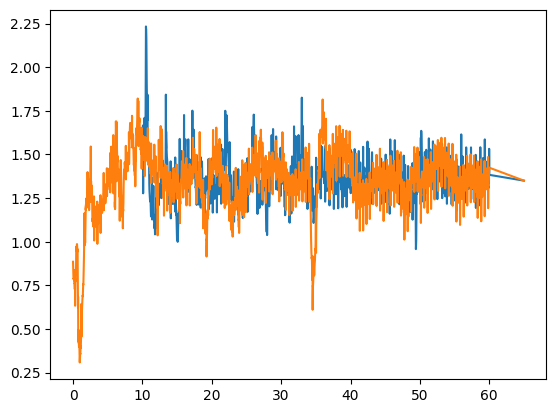

In [6]:
plt.plot(data["3"][0]["Time"], data["3"][0]["1"])
plt.plot(data["3"][1]["Time"], data["3"][1]["1"])
plt.show()

In [7]:
train_df = []
t = 0
ids = 0
for x in data:
    ids += len(data[x][0]["1"]) + len(data[x][1]["1"])
    train_df.extend([data[x][0]["1"], data[x][1]["1"]])
train_df = pd.DataFrame(pd.concat(train_df), columns=["1"])
train_df["time_indices"] = pd.to_datetime([*range(ids)], unit='s', origin=pd.Timestamp('2021-01-01 01:00:00', unit='s'))
train_df = train_df.set_index("time_indices").asfreq('S')
#train_df = pd.concat([train_df_ids, train_df_vals], axis=1)
'''validation_df = []
for x in validation:
    validation_df.extend([validation[x][0], validation[x][1]])
pd.concat(validation_df).to_csv("validation.csv", index_label="Time")'''
train_df

,1
time_indices,
2021-01-01 01:00:00,1.578218
2021-01-01 01:00:01,1.578611
2021-01-01 01:00:02,1.579003
2021-01-01 01:00:03,1.579003
2021-01-01 01:00:04,1.579003
...,...
2021-01-08 19:06:35,1.629587
2021-01-08 19:06:36,1.629587
2021-01-08 19:06:37,1.629587


In [8]:
df = train_df.copy(deep=True)
train_df = PandasDataset(train_df, target="1", freq="S")
train_df

PandasDataset<size=1, freq=S, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [9]:
training_data, test_gen = split(train_df, offset=-10000)
test_data = test_gen.generate_instances(prediction_length=10000, windows=1)

In [10]:
model = DeepAREstimator(
    prediction_length=10000, freq="S", trainer_kwargs={"max_epochs": 5}
).train(training_data)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params | In sizes                                                               | Out sizes      
---------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.1 K | [[1, 1], [1, 1], [1, 10181, 7], [1, 10181], [1, 10181], [1, 10000, 7]] | [1, 100, 10000]
---------------------------------------------------------------------------------------------------------------------------------
25.1 K    Trainable params
0         Non-trainable params
25.1 K    Total params
0.100     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 0.00123 (best 0.00123), saving model to '/Users/filipp/PycharmProjects/pythonProject/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached -0.82391 (best -0.82391), saving model to '/Users/filipp/PycharmProjects/pythonProject/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached -1.15049 (best -1.15049), saving model to '/Users/filipp/PycharmProjects/pythonProject/lightning_logs/version_1/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached -1.31780 (best -1.31780), saving model to '/Users/filipp/PycharmProjects/pythonProject/lightning_logs/version_1/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


In [11]:
forecasts = list(model.predict(test_data.input))

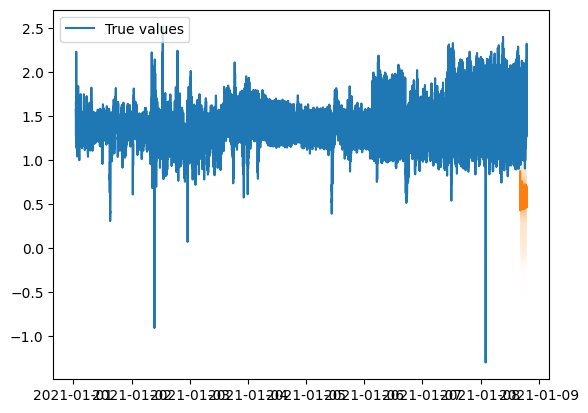

In [12]:
plt.plot(df["1"])
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left")
plt.show()

In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

true = list(df["1"])[-10000:]
pred = forecasts[-1].samples[-1]
print("MSE:", mean_squared_error(true, pred))
print("RMSE:", np.sqrt(mean_squared_error(true, pred)))
print("MAE:", mean_absolute_error(true, pred))
print("MAPE:", mean_absolute_percentage_error(true, pred))
print("R2:", r2_score(true, pred))

MSE: 0.9103819257023701
RMSE: 0.9541393638784483
MAE: 0.810941141591539
MAPE: 59.56055338454469
R2: -36.71163832993019


# Prophet

/var/folders/p5/lrpx83fd6vbch0znz3q6vz4c0000gn/T/ipykernel_14871/3405435327.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ds"] = pd.to_datetime(df["ds"]*1000, unit='s')


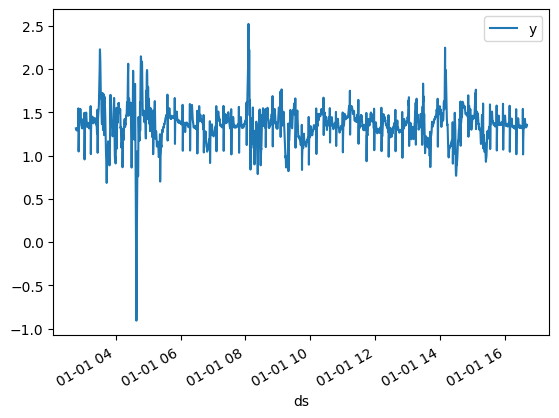

In [241]:
# prophet forecast for 3
df = data["5"][0][["Time", "1"]]
df.columns = ["ds", "y"]
# convert ms to datetime
df["ds"] = pd.to_datetime(df["ds"]*1000, unit='s')

df.plot(x="ds", y="y")
plt.show()

In [242]:
df['ds']

0       1970-01-01 02:46:40
1       1970-01-01 02:46:41
2       1970-01-01 02:46:42
3       1970-01-01 02:46:43
4       1970-01-01 02:46:44
                ...        
49994   1970-01-01 16:39:54
49995   1970-01-01 16:39:55
49996   1970-01-01 16:39:56
49997   1970-01-01 16:39:57
49998   1970-01-01 16:39:58
Name: ds, Length: 49999, dtype: datetime64[ns]

In [268]:
# model
# m = prophet.Prophet(changepoint_prior_scale=0.5, seasonality_mode='multiplicative')
# m.fit(df)
m = prophet.Prophet(growth='linear', seasonality_mode='multiplicative', seasonality_prior_scale=10, )
m.fit(df)


16:21:09 - cmdstanpy - INFO - Chain [1] start processing
16:21:16 - cmdstanpy - INFO - Chain [1] done processing


In [261]:

future = m.make_future_dataframe(periods=1, freq='H')
forecast = m.predict(future)

In [251]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
50994,1970-01-01 16:56:34,1.338804,1.090297,1.579305,1.316541,1.359241,0.0,0.0,0.0,0.0,0.0,0.0,1.338804
50995,1970-01-01 16:56:35,1.338802,1.106700,1.589408,1.316495,1.359277,0.0,0.0,0.0,0.0,0.0,0.0,1.338802
50996,1970-01-01 16:56:36,1.338800,1.086994,1.582904,1.316443,1.359312,0.0,0.0,0.0,0.0,0.0,0.0,1.338800
50997,1970-01-01 16:56:37,1.338798,1.098661,1.596467,1.316392,1.359348,0.0,0.0,0.0,0.0,0.0,0.0,1.338798
50998,1970-01-01 16:56:38,1.338796,1.084727,1.593362,1.316341,1.359383,0.0,0.0,0.0,0.0,0.0,0.0,1.338796


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


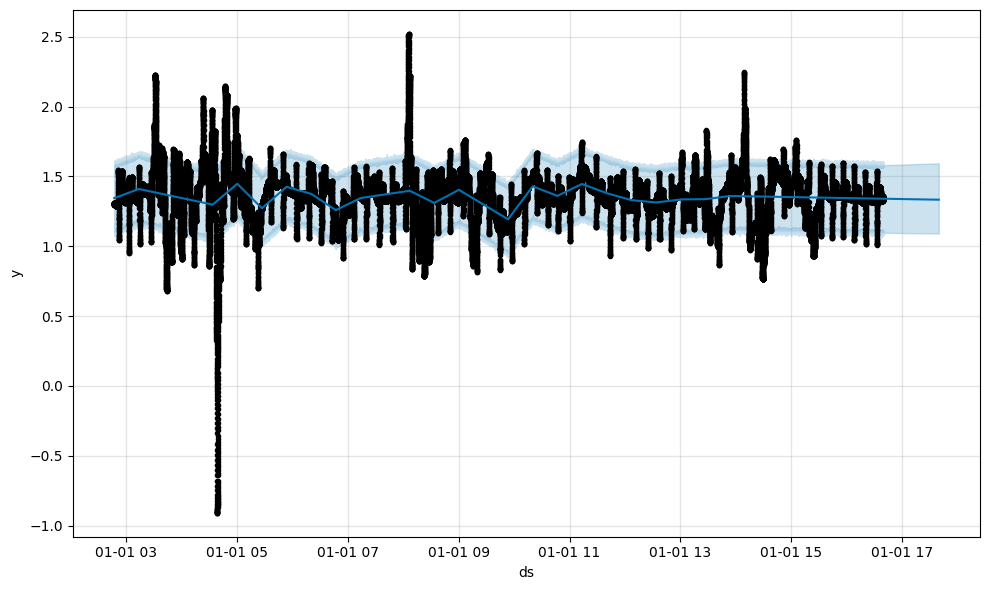

In [262]:
# plot
fig = m.plot(forecast)

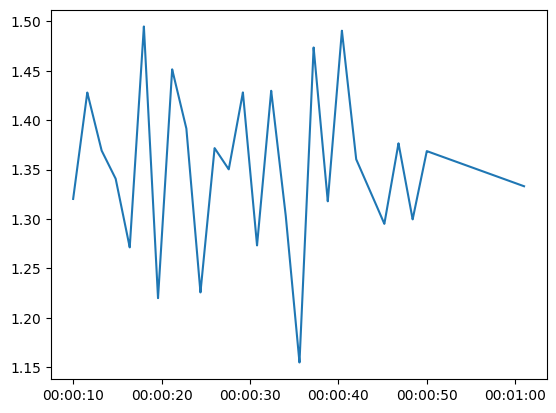

In [192]:
plt.plot(forecast["ds"], forecast["yhat"])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


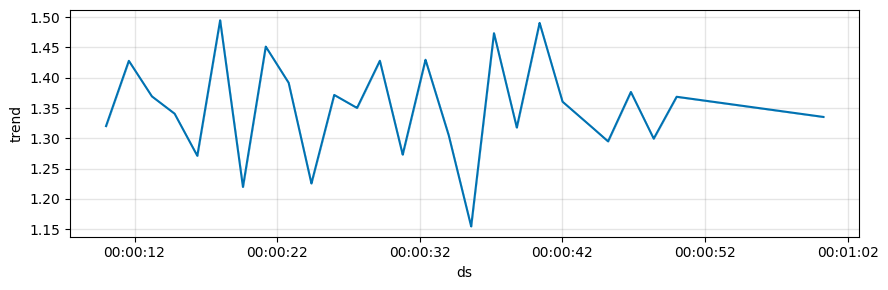

In [181]:
fig = m.plot_components(forecast)